In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from datetime import timedelta

In [ ]:
# 讀取資料
file_path = 'output.csv'
data = pd.read_csv(file_path)

In [ ]:
# 計算每個訂單的營業額
data['revenue'] = data['unit_price'] * data['quantity']

# 將時間戳轉換為 datetime 格式
data['time'] = pd.to_datetime(data['time'], unit='ns')

# 按天匯總營業額
daily_revenue = data.groupby(data['time'].dt.date)['revenue'].sum().reset_index()
daily_revenue

,time,revenue
0,2023-08-16,8457
1,2023-08-17,48093
2,2023-08-18,39267
3,2023-08-19,46359
4,2023-08-20,27768
...,...,...
360,2024-08-10,40101
361,2024-08-11,64239
362,2024-08-12,55509
363,2024-08-13,35883


In [ ]:
# 正規化數據
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(daily_revenue['revenue'].values.reshape(-1, 1))
# scaled_data

In [ ]:
# 準備訓練資料
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    print(f"Generated {len(X)} sequences.")
    return np.array(X), np.array(Y)

time_step = 20
X, Y = create_dataset(scaled_data, time_step)
print(f"Shape of X: {X.shape}")
print(f"Shape of Y: {Y.shape}")

if X.size == 0 or Y.size == 0:
    raise ValueError("Insufficient data to generate sequences. Consider reducing the time_step.")

X = X.reshape(X.shape[0], X.shape[1], 1)
# X

Generated 344 sequences.
Shape of X: (344, 20)
Shape of Y: (344,)


In [ ]:
# 建立 LSTM 模型
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# 編譯模型
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# 編譯模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 訓練模型
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.fit(X, Y, batch_size=1, epochs=100, validation_split=0.2, callbacks=[early_stopping])

# 保存模型到文件
model.save("revenue_prediction_model.h5")

Epoch 1/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0239 - val_loss: 0.0300
Epoch 2/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0266 - val_loss: 0.0258
Epoch 3/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0253 - val_loss: 0.0261
Epoch 4/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0247 - val_loss: 0.0263
Epoch 5/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0244 - val_loss: 0.0258
Epoch 6/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0252 - val_loss: 0.0262
Epoch 7/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0222 - val_loss: 0.0264
Epoch 8/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0229 - val_loss: 0.0269


In [ ]:
# 从文件加载模型
# model = tf.keras.models.load_model("revenue_prediction_model.h5")

In [ ]:
# 預測未來的營業額
future_steps = 7
last_days = scaled_data[-time_step:]
# print(last_days)
# print("=======last_days======\n")
pred_input = last_days.reshape(1, time_step, 1)
# print("=======pred_input======\n")
predictions = []

for _ in range(future_steps):
    pred = model.predict(pred_input)
    predictions.append(pred[0, 0])
    # 重塑 pred 以匹配 pred_input 的尺寸
    pred = pred.reshape(1, 1, 1)
    pred_input = np.append(pred_input[:, 1:, :], pred, axis=1)
# print(pred_input)
# print("=======pred_input======\n")
# print(predictions)
# print("=======predictions======\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [ ]:
# 將預測結果轉換回原始範圍
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
predictions

array([[43233.312],
       [42219.8  ],
       [41796.863],
       [41641.133],
       [41691.508],
       [41824.94 ],
       [41986.816]], dtype=float32)

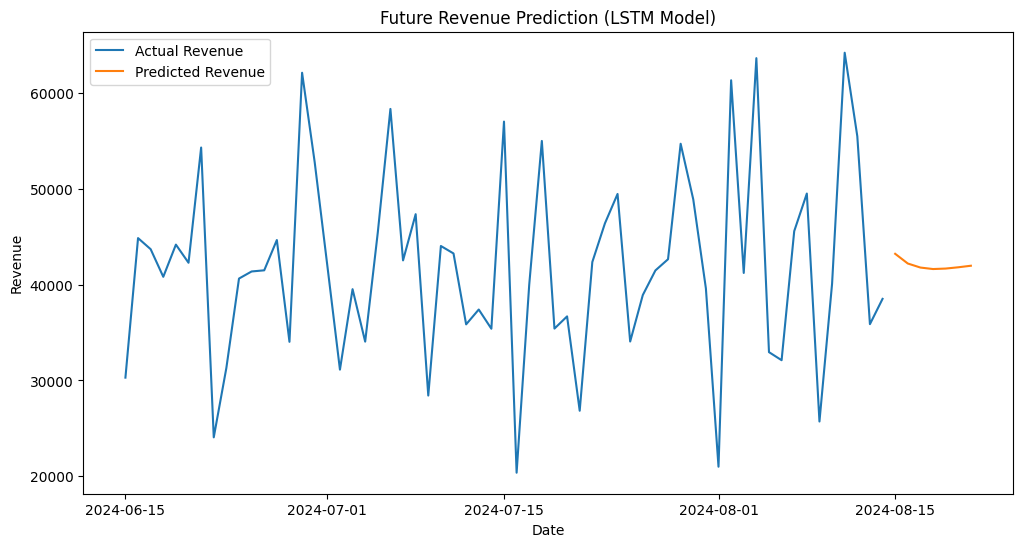

In [ ]:
# 生成未來7天的日期範圍
future_dates = pd.date_range(start=daily_revenue['time'].iloc[-1], periods=future_steps + 1, freq='D')[1:]

# 確定要顯示的日期範圍：最后两个月的数据
two_months_ago = daily_revenue['time'].max() - timedelta(days=60)
recent_data = daily_revenue[daily_revenue['time'] >= two_months_ago]

# 繪製預測結果
plt.figure(figsize=(12, 6))
plt.plot(recent_data['time'], recent_data['revenue'], label='Actual Revenue')
plt.plot(future_dates, predictions, label='Predicted Revenue')
plt.title('Future Revenue Prediction (LSTM Model)')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.show()